In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

from gammapy.irf import load_cta_irfs
from gammapy.makers import SpectrumDatasetMaker
from gammapy.data import Observation
from gammapy.estimators import SensitivityEstimator
from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff
from gammapy.maps import MapAxis

from DarkMatter import *
from scipy.interpolate import interp1d

Welcome to JupyROOT 6.23/01


Text(0.5, 0, 'Energy [GeV]')

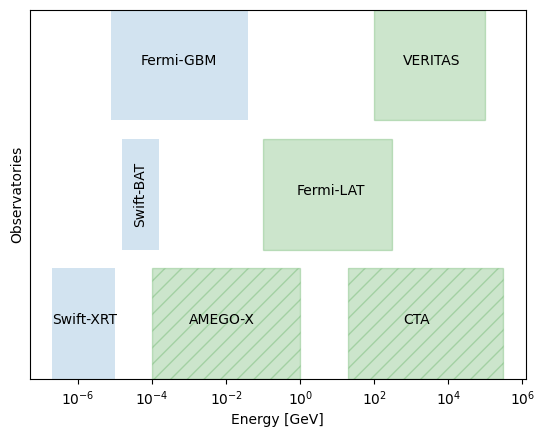

In [14]:
plt.ylabel("Observatories")
plt.text(0.2/1e6, 0.15, "Swift-XRT")
plt.text(30/1e6, 0.5, "Swift-BAT", rotation=90, va="center")
plt.text(50/1e6, 0.85, "Fermi-GBM")
plt.text(1000/1e6, 0.15, "AMEGO-X")
plt.text(0.8, 0.5, "Fermi-LAT")
plt.text(600, 0.85, "VERITAS")
plt.text(600, 0.15, "CTA")

plt.axvspan(0.2/1e6, 10/1e6, ymax=0.3, alpha=0.2)
plt.axvspan(15/1e6, 150/1e6, ymin=0.35, ymax=0.65, alpha=0.2)
plt.axvspan(8/1e6, 0.04, ymin=0.7, ymax=1, alpha=0.2)
plt.axvspan(100/1e6, 1, ymax=0.3, alpha=0.2, color="green", hatch="//")
plt.axvspan(0.1, 300, alpha=0.2, ymin=0.35, ymax=0.65, color="green")
plt.axvspan(100, 100000, alpha=0.2, ymin=0.7, ymax=1, color="green")
plt.axvspan(20, 300000, alpha=0.2, ymin=0, ymax=0.3, color="green", hatch="//")


plt.yticks([])
plt.xscale("log")
plt.xlabel("Energy [GeV]")

In [8]:
plt.style.use("default")

## Import CTA response

In [20]:
ra = "151.767 deg"
dec = "16.082 deg"

center = SkyCoord(ra, "16.582 deg")  #center = SkyCoord("0 deg", "0.5 deg")
region = CircleSkyRegion(center=center, radius=np.sqrt(0.03) * u.deg)

e_reco = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=20)
e_true = MapAxis.from_energy_bounds(
    "0.1 TeV", "100 TeV", nbin=20, name="energy_true"
)

empty_dataset = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=region
)

filename = const.REF_DIR+"/CTA/used/Prod5-North-20deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits"

irfs = load_cta_irfs(filename)

pointing = SkyCoord(ra, dec)
obs = Observation.create(pointing=pointing, irfs=irfs, livetime="50 h")

spectrum_maker = SpectrumDatasetMaker(
    selection=["exposure", "edisp", "background"]
)
dataset = spectrum_maker.run(empty_dataset, obs)

In [21]:
on_size = np.sqrt(0.03)*u.deg
alpha = 0.131
th2Cut = 0.03

on_radii = obs.psf.containment_radius(
    energy=e_reco.center, theta=0.5 * u.deg, fraction=0.68
)[0]

dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=5
)

sensitivity_estimator = SensitivityEstimator(
    gamma_min=5, n_sigma=5, bkg_syst_fraction=0.10
)

sensitivity_table = sensitivity_estimator.run(dataset_on_off)


## Generate J profile

In [22]:
dwarf = "segue_1"
gJProf = JProfile.calcJProfile(dwarf, seed=defaultNum[dwarf], step=0.002)
jprof = []
for e, r in zip(e_true.center, on_radii.deg):
    gPSF1D_fake = ResponseFunction.fakePSF(r, step=0.002)
    J_fake, temp = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS", th2Cut=th2Cut)
    jprof.append([e*1e3/u.TeV, J_fake])
jprof.append([1e9, J_fake])
jprof=np.asarray(jprof)
jProfile_cta = interp1d(jprof[:,0], jprof[:,1])

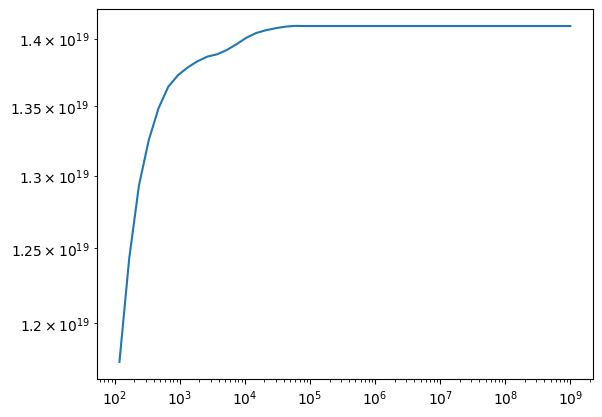

In [23]:
plt.plot(jprof[:,0], jprof[:,1])
plt.xscale("log")
plt.yscale("log")

## Get IRFs

In [24]:
newirf = ResponseFunction.newirf("VEGAS")

newirf.exposure = 1

### - Effective area

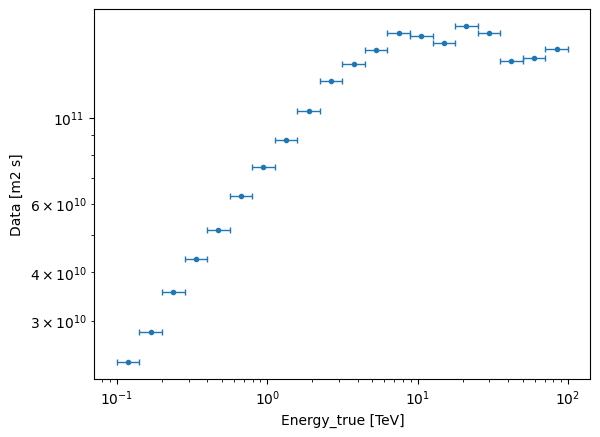

In [25]:
EA_plot = dataset_on_off.exposure.plot()

EA = np.asarray([np.log10(EA_plot.get_children()[1].get_xdata()/u.TeV), EA_plot.get_children()[1].get_ydata()]).T
newirf.EA = ResponseFunction.fakeEA(EA, benchmark="VEGAS")

### - Energy bias

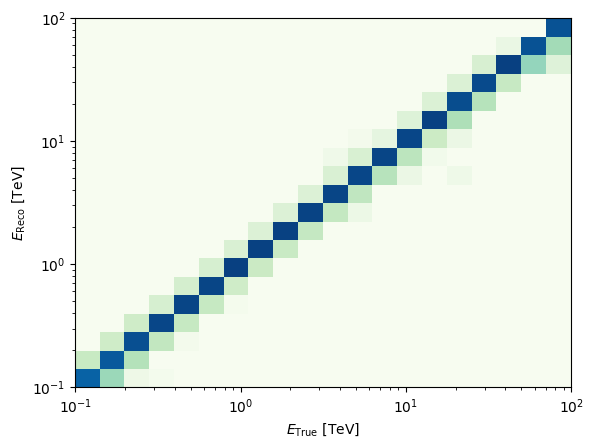

Warning in <TROOT::Append>: Replacing existing TH1: DispersionMatrix (Potential memory leak).


In [26]:
disp = dataset_on_off.edisp.get_edisp_kernel()
disp.plot_matrix()
newirf.Edisp = ResponseFunction.fakeDisp(disp.energy_axis_true.edges/u.TeV*1e3, 
                  disp.energy_axis.edges/u.TeV*1e3, disp.pdf_matrix )

### - Background rate

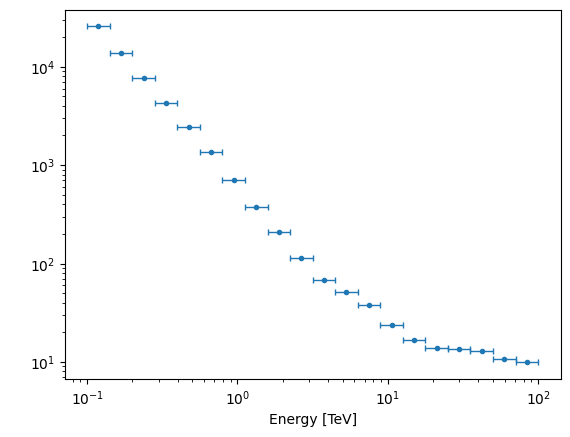

In [27]:
bkg = dataset_on_off.counts_off.plot()
bkg = np.asarray([np.log10(bkg.get_children()[1].get_xdata()/u.TeV), bkg.get_children()[1].get_ydata()]).T

## Calculate expected events

In [28]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$", r"\nu_e \bar{\nu_e}"]

mass = np.logspace(4.5, 7.5, 30)

cnts = {}
Eedges = np.asarray(e_reco.edges)*1e3
for c in chan:
    cnts[c] = []
    if c == "gamma":
        z, M, y = getArray(newirf.Edisp)
        mass = M[(M>10**4.5)*(M<10**7.5)].tolist() + mass[mass>max(M)].tolist()
    for en in tqdm(mass):
        
        sig_CTA_hdm = Likelihood.calcSignal(dwarf, en, newirf, jArray=True, eLowerCut=100,
                      jProfile=jProfile_cta, DM_spectra="HDM", channel=c, energyEdges = Eedges)

        cnts[c].append([en, sum(getArray(sig_CTA_hdm)[1])])
    cnts[c] = np.asarray(cnts[c])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

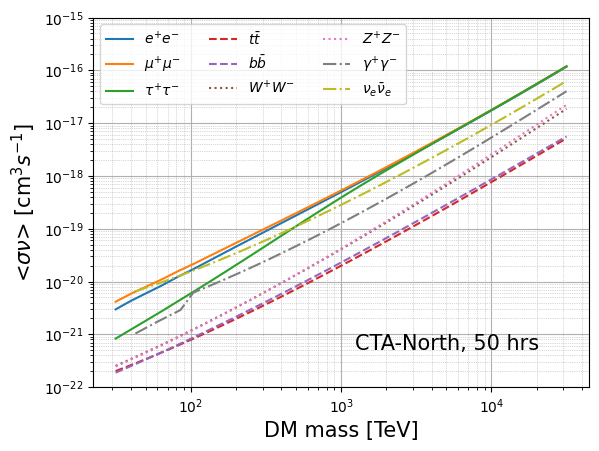

In [29]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma", "nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$", 
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma^{+}\gamma^{-}$", r"$\nu_e \bar{\nu}_e$"]


ls = ["-", "-", "-", "--", "--", ":",":", "-.", "-."]
mass = np.logspace(4.5, 7.5, 30)
sigma = np.logspace(-24, -15, 35)

N_bkg = sum(bkg[:,1])/alpha

for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
    if c == "gamma":
        z, M, y = getArray(newirf.Edisp)
        mass = M[(M>10**4.5)*(M<10**7.5)].tolist() + mass[mass>max(M)].tolist()
    five_sig = []
    for i, m in enumerate(mass):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+cnt[i][1]*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(np.asarray(mass)/1e3, 10**five_sig,  label=cl, ls=l)
    data = np.array([np.asarray(mass)/1e3, 10**five_sig]).T
    np.save(f"cta_like_{c}_disc", data)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-22, 1e-15)
plt.grid()

plt.legend(ncol=3)
plt.xlabel("DM mass [TeV]", fontsize=15)
plt.ylabel(r"<$\sigma\nu$> [cm$^{3}s^{-1}$]", fontsize=15)
ax = plt.gca()
plt.text(0.9, 0.1, "CTA-North, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
plt.grid(b=True, which="major")
plt.grid(b=True, which="minor", ls=":", lw=0.5)
    
plt.savefig("CTA_disc.pdf")

## Generate a discovery map

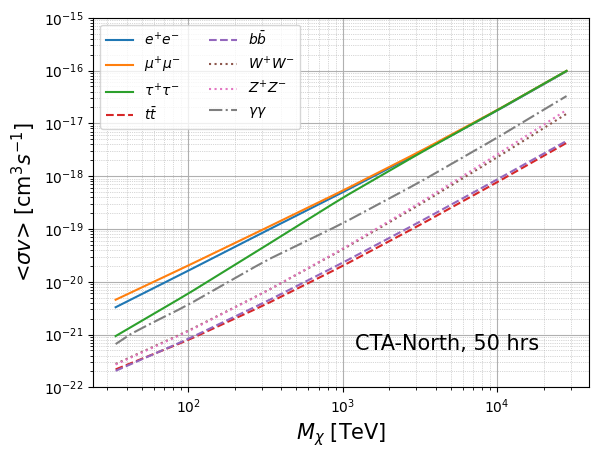

In [18]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]
mass = np.logspace(1.53, 4.45, 30)
sigma = np.logspace(-22, -15, 30)

N_bkg = sum(bkg[:,1])/alpha

for c, cl, l in zip(chan, chan_lab, ls):
    M = cnts[c][:,0]
    cnt = cnts[c]
    f_mass = interp1d(np.log10(M/1e3), np.log10(cnt[:,1]))
    five_sig = []
    for i, m in enumerate(mass):
        temp = []
        for j, s in enumerate(sigma):
            sig = LiMaSiginficance(N_bkg*alpha+10**f_mass(np.log10(m))*s/1e-23, N_bkg, alpha=alpha)
            temp.append(sig)
        test = interp1d(np.log10(temp), np.log10(sigma))
        five_sig.append(test(np.log10(5)))
    five_sig = np.asarray(five_sig)
    plt.plot(mass, 10**five_sig,  label=cl, ls=l)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-22, 1e-15)
plt.grid()

plt.legend(ncol=2)
plt.xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)
plt.ylabel(r"<$\sigma v$> [cm$^{3}s^{-1}$]", fontsize=15)
ax = plt.gca()
plt.text(0.9, 0.1, "CTA-North, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
plt.grid(b=True, which="major")
plt.grid(b=True, which="minor", ls=":", lw=0.5)
    
plt.savefig("CTA_disc.pdf")

## Calculate upper limits

### - Unbinned

In [9]:
from DarkMatter.Likelihood.simulation import gen_evt_1d

N_cta = sum(bkg[:,1])
alpha=0.2
new_evts = gen_evt_1d(bkg, alpha=alpha)
eventset = np.asarray([[evt[0]*1e3, 0, 0, 0.2] for evt in new_evts])
hOn, hOff = Likelihood.eventdisplay.readData(dwarf, events=eventset)

In [20]:
dwarf = "segue_1"
mass = np.logspace(4.5, 7.5, 5)
jSeed=defaultNum[dwarf]
package="VEGAS"

chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]


for channel in chan:
    filename = "cta_{}".format(channel)
    if channel == "gamma":
        z, mass, y = getArray(newirf.Edisp)
        mass = mass.tolist() + np.logspace(4.5, 7.5, 5)[np.logspace(4.5, 7.5, 5)>max(mass)].tolist()
        mass = np.asarray(mass)
        mass = mass[mass>10**4.5]
    Likelihood.calcExpectedLimits(dwarf, channel, package=package, irf = newirf, mass=mass, method=2, averagedIRF=True, DM_spectra="HDM",
                                  jArray=True, jSeed=jSeed, jProfile=jProfile_cta, addTheta=False, version="all", ext=False, multi=True,
                                  useBias=False, verbosity=0, runs=100, filename=filename, test=True, 
                                  N_on=int(N_cta), events=eventset, alpha = alpha, hOff=hOff, N_off=int(N_cta/alpha))

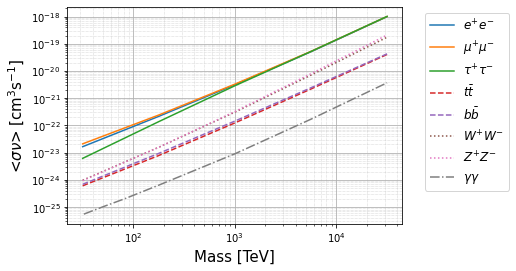

In [3]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "cta_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)


### - Binned

In [47]:
Eedges

array([1.00000000e+02, 1.41253754e+02, 1.99526231e+02, 2.81838293e+02,
       3.98107171e+02, 5.62341325e+02, 7.94328235e+02, 1.12201845e+03,
       1.58489319e+03, 2.23872114e+03, 3.16227766e+03, 4.46683592e+03,
       6.30957344e+03, 8.91250938e+03, 1.25892541e+04, 1.77827941e+04,
       2.51188643e+04, 3.54813389e+04, 5.01187234e+04, 7.07945784e+04,
       1.00000000e+05])

In [14]:
ts_all = []
runs = 100

mass = np.logspace(4.5, 7.5, 10)

dwarf="segue_1"
chan = ["nue"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

#pbar = tqdm(total=len(mass)*runs*len(chan))
h_off = convertHist(bkg[:,0], bkg[:,1])
Eedges = np.asarray(e_reco.edges)*1e3
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)

for c in chan:
    filename="cta_like_{}".format(c)
    ul = {}
    
    if c == "gamma":
        mass = np.logspace(4.5, 7.5, 10)
        mass = Eedges[Eedges>=10**(4.5)].tolist()+mass[mass>=1e5].tolist()
        mass.append(1.1e5)
        mass.sort()
        print(mass)
#        mass = Eedges[Eedges>=10**(4.5)].tolist()+[1e5]
#        mass = [1.1e5]
    

    for M in mass:
        print(M)
        ul[M] = []
        
        
    for i, M in enumerate(mass):
        h_sig = Likelihood.calcSignal(dwarf, M, newirf, jArray=True, eLowerCut=100,
                      jProfile=jProfile_cta, DM_spectra="HDM", channel=c, energyEdges = Eedges)
        for j in trange(runs):
        
            hOn = np.zeros_like(bkg[:,1])
            for k, b in enumerate(bkg[:,1]):
                hOn[k] = np.random.poisson(b)
                
            h_on = convertHist(bkg[:,0], hOn)
            
            mle = Likelihood.MLE(dwarf, M, "VEGAS", channel=c, irf=newirf, jProfile=jProfile_cta, 
                    th2Cut=0.03, addTheta=False, 
                    averagedIRF=True, version="all", 
                    seed=5, expectedLimit=True, 
                    bkgModel=None, ext=False,
                    verbose=False, statistic="binned", DM_spectra="HDM", alpha = alpha, events=events,
                    hSignal=h_sig, hOff = h_off, hOn=h_on, N_on=sum(hOn), N_off=sum(bkg[:,1])/alpha)
        
            mle.minuit(method=2, upperLimit=True, fix_b=False)
            ts_all.append(mle.ts)
            
            if mle.ts > 10:
                print("Error!")
            if not(np.isnan(mle.signu_ul)):
                ul[M].append(mle.signu_ul)

            #pbar.update(1)

    np.save(const.OUTPUT_DIR+filename, ul)

31622.776601683792
68129.20690579608
146779.92676220706
316227.7660168379
681292.0690579609
1467799.2676220676
3162277.6601683795
6812920.690579608
14677992.676220676
31622776.60168379


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/100 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
Error!


  0%|          | 0/100 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/100 [00:00<?, ?it/s]

Error!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  FUNCTION VALUE DOES NOT SEEM TO DEPEND ON ANY OF THE 2 VARIABLE PARAMETERS.
          VERIFY THAT STEP SIZES ARE BIG ENOUGH AND CHECK FCN LOGIC.
 *******************************************************************************
 *******************************************************************************


In [103]:
ts_all = []
runs = 1000

mass = np.logspace(4.5, 7.5, 10)

dwarf="segue_1"
chan = ["ttbar"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

#pbar = tqdm(total=len(mass)*runs*len(chan))
h_off = convertHist(bkg[:,0], bkg[:,1])
Eedges = np.asarray(e_reco.edges)*1e3
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)

for c in chan:
    filename="cta_like_{}_sys".format(c)
    ul = {}
    
    if c == "gamma":
        mass = np.logspace(4.5, 7.5, 10)
#        mass = Eedges[Eedges>=10**(4.5)].tolist()+[mass[mass>=1e5].tolist()]
        mass = Eedges[Eedges>=10**(4.5)].tolist()+[1e5]
        mass = [1.1e5]
    for M in mass:
        ul[M] = []
        
        
    for i, M in enumerate(mass):
        h_sig = Likelihood.calcSignal(dwarf, M, newirf, jArray=True, eLowerCut=100,
                      jProfile=jProfile_cta, DM_spectra="HDM", channel=c, energyEdges = Eedges)
        
        for j in trange(runs):
        
            hOn = np.zeros_like(bkg[:,1])
            for k, b in enumerate(bkg[:,1]):
                hOn[k] = np.random.poisson(b)
                
            h_on = convertHist(bkg[:,0], hOn)
            
            mle = Likelihood.MLE(dwarf, M, "VEGAS", channel=c, irf=newirf, jProfile=jProfile_cta, 
                    th2Cut=0.03, addTheta=False, 
                    averagedIRF=True, version="all", 
                    seed=5, expectedLimit=True, 
                    bkgModel=None, ext=False,
                    verbose=False, statistic="binned", DM_spectra="HDM", alpha = alpha, events=events,
                    hSignal=h_sig, hOff = h_off, hOn=h_on, N_on=sum(hOn), N_off=sum(bkg[:,1])/alpha)
        
            mle.minuit(method=2, upperLimit=True, fix_b=False)
            ts_all.append(mle.ts)
            
            if mle.ts > 10:
                print("Error!")
            if not(np.isnan(mle.signu_ul)):
                ul[M].append(mle.signu_ul)

            #pbar.update(1)

    np.save(const.OUTPUT_DIR+filename, ul)

  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
Error!
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/1000 [00:00<?, ?it/s]

Error!
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
Error!
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
Error!
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


  0%|          | 0/1000 [00:00<?, ?it/s]

Error!
Error!


  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minui

  0%|          | 0/1000 [00:00<?, ?it/s]

Error!


  0%|          | 0/1000 [00:00<?, ?it/s]

Error!


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [108]:
ts_all = []
runs = 1000

mass = np.logspace(4.5, 7.5, 5)

dwarf="segue_1"
chan = ["ttbar"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

#pbar = tqdm(total=len(mass)*runs*len(chan))
h_off = convertHist(bkg[:,0], bkg[:,1])
Eedges = np.asarray(e_reco.edges)*1e3
events = Likelihood.VEGAS.readData(dwarf, rawdata=True)

for c in chan:
    filename="cta_like_{}_jsys".format(c)
    ul = {}
    
    if c == "gamma":
        mass = np.logspace(4.5, 7.5, 10)
#        mass = Eedges[Eedges>=10**(4.5)].tolist()+[mass[mass>=1e5].tolist()]
        mass = Eedges[Eedges>=10**(4.5)].tolist()+[1e5]
        mass = [1.1e5]
    for M in mass:
        ul[M] = []
        
    for j in trange(runs):
        
        gJProf = JProfile.calcJProfile(dwarf, step=0.002)
        jprof = []
        for e, r in zip(e_true.center, on_radii.deg):
            gPSF1D_fake = ResponseFunction.fakePSF(r, step=0.002)
            J_fake, temp = JProfile.calcHKConvJProf2D(gJProf, gPSF1D_fake, package="VEGAS", th2Cut=th2Cut)
            jprof.append([e*1e3/u.TeV, J_fake])
        jprof.append([1e9, J_fake])
        jprof=np.asarray(jprof)
        jProfile_cta = interp1d(jprof[:,0], jprof[:,1])

        for i, M in enumerate(mass):
            h_sig = Likelihood.calcSignal(dwarf, M, newirf, jArray=True, eLowerCut=100,
                          jProfile=jProfile_cta, DM_spectra="HDM", channel=c, energyEdges = Eedges)
        
            hOn = np.zeros_like(bkg[:,1])
            for k, b in enumerate(bkg[:,1]):
                hOn[k] = b
                
            h_on = convertHist(bkg[:,0], hOn)
            
            mle = Likelihood.MLE(dwarf, M, "VEGAS", channel=c, irf=newirf, jProfile=jProfile_cta, 
                    th2Cut=0.03, addTheta=False, 
                    averagedIRF=True, version="all", 
                    seed=5, expectedLimit=True, 
                    bkgModel=None, ext=False,
                    verbose=False, statistic="binned", DM_spectra="HDM", alpha = alpha, events=events,
                    hSignal=h_sig, hOff = h_off, hOn=h_on, N_on=sum(hOn), N_off=sum(bkg[:,1])/alpha)
        
            mle.minuit(method=2, upperLimit=True, fix_b=False)
            ts_all.append(mle.ts)
            
            if mle.ts > 10:
                print("Error!")
            if not(np.isnan(mle.signu_ul)):
                ul[M].append(mle.signu_ul)

            #pbar.update(1)

    np.save(const.OUTPUT_DIR+filename, ul)

  0%|          | 0/1000 [00:00<?, ?it/s]

[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).
[Error] MIGRAD is NOT converged. Check initial parameters (minuit in mle.py).


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Warning in <TROOT::Append>: Replacing existing TH1: hg_1D (Potential memory leak).


In [74]:
x = np.load(const.OUTPUT_DIR+"cta_like_gamma_add.npy", allow_pickle=True).item()
y = np.load(const.OUTPUT_DIR+"cta_like_gamma.npy", allow_pickle=True).item()

In [75]:
for m in x.keys():
    y[m] = x[m]

In [76]:
yz = list(y.keys())

In [77]:
yz.sort()

In [78]:
yz

[31622.776601683792,
 35481.33892335757,
 50118.723362727236,
 70794.5784384138,
 100000.0,
 100000.00000000004,
 110000.0,
 177827.94100389228,
 1000000.0,
 5623413.251903491,
 31622776.60168379]

In [79]:
z = {}
for m in yz:
    z[m] = y[m]

In [80]:
np.save(const.OUTPUT_DIR+"cta_like_gamma.npy", z)

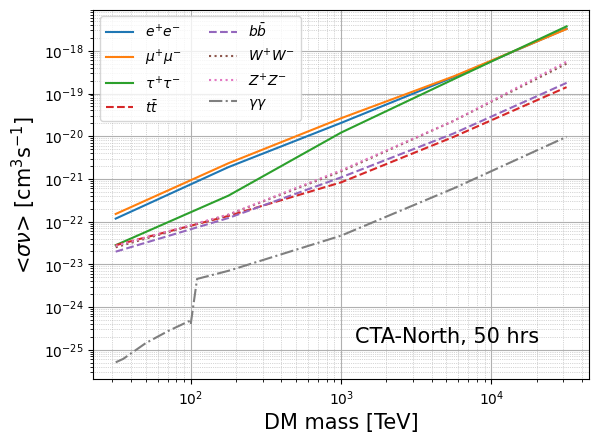

In [82]:
chan = ["ee", "uu", "tt", "ttbar", "bbar", "WW", "ZZ", "gamma"]
chan_lab = [r"$e^{+}e^{-}$", r"$\mu^{+}\mu^{-}$", r"$\tau^{+}\tau^{-}$",
            r"$t\bar{t}$", r"$b\bar{b}$",
            r"$W^{+}W^{-}$", r"$Z^{+}Z^{-}$", r"$\gamma\gamma$"]

ls = ["-", "-", "-", "--", "--", ":",":", "-."]

for c, cl, l in zip(chan, chan_lab, ls):
    filename = "cta_like_"+c
    Likelihood.plotExpULcurve(filename=filename, label=cl, units="TeV", ls=l, mean_only=True)
plt.legend(loc=2, ncol=2)

ax = plt.gca()
plt.text(0.9, 0.1, "CTA-North, 50 hrs", fontsize=15, ha="right", transform=ax.transAxes)
#plt.text(0.9, 0.2, "95% upper limits", fontsize=15, ha="right", transform=ax.transAxes)
plt.xlabel("DM mass [TeV]", fontsize=15)
plt.savefig("CTA_ULs.pdf")